# Book Recommendation System with Amazon Review Data

   ## Ratings Model
   ## Description/Text Reviews Vectorization Model

In [3]:
import os
#import json
import ujson as json
import gzip
import pandas as pd
from urllib.request import urlopen

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import RidgeCV, LinearRegression, SGDRegressor, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix
import scipy.sparse

## Loading Data

Here, we are using Amazon review data that was crawled from user reviews in the range of 1996 to 2018. The size of data is big > a few GB, so I am using a subset of data first to check to model working.

In [5]:
children_books = []
for line in gzip.open('../meta_Books.json.gz', 'rt'):
    if "Child" in line:
        children_books.append(line)

In [6]:
len(children_books)

290993

In [7]:
cbooks = []
for i in range(len(children_books)):
    cbooks.append(json.loads(children_books[i]))

In [8]:
df_meta = pd.DataFrame(cbooks)
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Books, Children's Books, Activities, Crafts &...",,[],,Chess for Children,[],,Raymond Bott,[],"2,703,396 in Books (",[],Books,,,$5.39,0001061100,[],[],NaN
1,"[Books, Children's Books, Literature & Fiction]",,[Collection of Poetry],,The golden treasury of poetry,"[0140556125, 0307165221, 0689823827, 000255834...",,Louis (ed) UNTERMEYER,[],"321,557 in Books (","[B001HDIKYW, B000LTQDP6, 0307168514, 039485010...",Books,,,$23.98,0001061240,[],[],NaN
2,"[Books, Children's Books]",,[],,Dinosaurs: a pop-up book,[],,Dorothea BARLOWE,[],"2,762,792 in Books (","[0763622281, 0763662356]",Books,,,$5.54,0001062395,[],[],NaN
3,"[Books, Children's Books]",,[],,Hilda Boswell's Treasury of Children's Stories,"[0001203010, 083174474X, 0001934503, 0001203037]",,Visit Amazon's Hilda Boswell Page,[],"2,214,417 in Books (","[0001203010, 0001203029]",Books,,,$62.47,0001203045,[],[],NaN
4,"[Books, Children's Books, Education & Reference]",,"[Sailing explores the world of small boats, in...",,Sailing,[],,Visit Amazon's Robin Knox-Johnston Page,[],"15,464,546 in Books (",[],Books,,,$6.47,0001001787,[],[],NaN


In [9]:
asin_list = df_meta['asin'].unique()

In [10]:
asin_set = set(df_meta['asin'].unique().flatten())

In [11]:
children_review = []
for line in gzip.open('reviews_Books_5.json.gz', 'rt'):
    row = json.loads(line)
    if row['asin'] in asin_set:
        children_review.append(row)

In [12]:
df_review = pd.DataFrame(children_review)

In [13]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396210 entries, 0 to 396209
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      396210 non-null  object 
 1   asin            396210 non-null  object 
 2   reviewerName    395483 non-null  object 
 3   helpful         396210 non-null  object 
 4   reviewText      396210 non-null  object 
 5   overall         396210 non-null  float64
 6   summary         396210 non-null  object 
 7   unixReviewTime  396210 non-null  int64  
 8   reviewTime      396210 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 27.2+ MB


In [14]:
df_meta_part = df_meta[['category', 'description', 'title', 'also_buy', 'brand', 
                             'also_view', 'asin']]

In [16]:
df_merge = df_review.merge(df_meta_part, how='inner', on='asin')

In [17]:
df_merge.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,description,title,also_buy,brand,also_view
0,A3RZNH3OPW1XMB,000171287X,CA_Kathy,"[0, 0]",for getting your kid introduced to his/her ABC...,5.0,Great,1375401600,"08 2, 2013","[Books, Children's Books, Literature & Fiction]","[In the B Book, the youngest child will be ent...",The Berenstains' B Book (Bright &amp; Early Bo...,"[067988632X, 0679887059, 0679886303, B000RAEBL...",Visit Amazon's Stan Berenstain Page,"[0394823249, B0015R555M, 0679890483, 067988705..."
1,AZGXZ2UUK6X,000171287X,"Catherine Hallberg ""(Kate)""","[1, 3]","This Book is funny and is full of B words, lik...",3.0,A celebration of B,1061078400,"08 17, 2003","[Books, Children's Books, Literature & Fiction]","[In the B Book, the youngest child will be ent...",The Berenstains' B Book (Bright &amp; Early Bo...,"[067988632X, 0679887059, 0679886303, B000RAEBL...",Visit Amazon's Stan Berenstain Page,"[0394823249, B0015R555M, 0679890483, 067988705..."
2,A2K28JHMIY3XKZ,000171287X,Charles Andrews,"[2, 2]",A favorite Berenstain book of my children I wa...,5.0,Big B Believer,1001894400,"10 1, 2001","[Books, Children's Books, Literature & Fiction]","[In the B Book, the youngest child will be ent...",The Berenstains' B Book (Bright &amp; Early Bo...,"[067988632X, 0679887059, 0679886303, B000RAEBL...",Visit Amazon's Stan Berenstain Page,"[0394823249, B0015R555M, 0679890483, 067988705..."
3,A1Z54EM24Y40LL,000171287X,csm,"[0, 0]",This book is quite funny. Especially when you...,5.0,"Very funny book, sad ending though!",1108080000,"02 11, 2005","[Books, Children's Books, Literature & Fiction]","[In the B Book, the youngest child will be ent...",The Berenstains' B Book (Bright &amp; Early Bo...,"[067988632X, 0679887059, 0679886303, B000RAEBL...",Visit Amazon's Stan Berenstain Page,"[0394823249, B0015R555M, 0679890483, 067988705..."
4,A179R0UL62Q36Z,000171287X,Gena R Kyle,"[0, 0]",Teaching the next generation to love books! M...,5.0,Child's book,1345680000,"08 23, 2012","[Books, Children's Books, Literature & Fiction]","[In the B Book, the youngest child will be ent...",The Berenstains' B Book (Bright &amp; Early Bo...,"[067988632X, 0679887059, 0679886303, B000RAEBL...",Visit Amazon's Stan Berenstain Page,"[0394823249, B0015R555M, 0679890483, 067988705..."


## Start Recommending Books

In [18]:
# drop one user reviewing the same book multiple times
df_merge_new = df_merge.drop_duplicates(['title', 'reviewerID'])

In [17]:
# os.makedirs('data', exist_ok=True)  
# df_merge_new.to_csv('data/df_merge.csv', index=False) 

In [5]:
df_merge_new_in = pd.read_csv('data/df_merge.csv')

In [130]:
df_merge_new_in.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,description,title,also_buy,brand,also_view
0,A3RZNH3OPW1XMB,000171287X,CA_Kathy,"[0, 0]",for getting your kid introduced to his/her ABC...,5.0,Great,1375401600,"08 2, 2013","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06..."
1,AZGXZ2UUK6X,000171287X,"Catherine Hallberg ""(Kate)""","[1, 3]","This Book is funny and is full of B words, lik...",3.0,A celebration of B,1061078400,"08 17, 2003","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06..."
2,A2K28JHMIY3XKZ,000171287X,Charles Andrews,"[2, 2]",A favorite Berenstain book of my children I wa...,5.0,Big B Believer,1001894400,"10 1, 2001","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06..."
3,A1Z54EM24Y40LL,000171287X,csm,"[0, 0]",This book is quite funny. Especially when you...,5.0,"Very funny book, sad ending though!",1108080000,"02 11, 2005","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06..."
4,A179R0UL62Q36Z,000171287X,Gena R Kyle,"[0, 0]",Teaching the next generation to love books! M...,5.0,Child's book,1345680000,"08 23, 2012","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06..."


### 1. By Ratings
Here, we create a pivot table which has indices of book titles, columns of reviewer ID and the values of the overall ratings. We fill the null values with zeroes. This is to use collaborative-filtering based on user ratings for each book. 

In [4]:
chunk_size = 5000
chunks = [x for x in range(0, df_merge_new_in.shape[0], chunk_size)]

# for i in range(0, len(chunks) - 1):
#     print(chunks[i], chunks[i + 1] - 1)

In [5]:
df_merge_pivot = pd.concat([df_merge_new_in.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot_table(index='title', columns='reviewerID', values='overall') for i in range(0, len(chunks) - 1)])
#df_merge_pivot = df_merge_new.pivot_table(index='title', columns='reviewerID', values='overall')


In [6]:
df_merge_pivot.fillna(0, inplace=True)
#df_merge_pivot

In [ ]:
#df_merge_pivot.to_csv('data/pivot_table.csv')

In [7]:
len(df_merge_pivot)

21908

In [7]:
df_merge_matrix = csr_matrix(df_merge_pivot)

In [8]:
df_merge_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
scipy.sparse.save_npz('data/sparse_matrix.npz', df_merge_matrix)

In [9]:
sparse_matrix = scipy.sparse.load_npz('data/sparse_matrix.npz')

In [10]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
#model_knn = NearestNeighbors(metric='cosine', algorithm='ball_tree')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [40]:
df_merge_review = pd.read_csv('data/df_merge_review_title.csv')

In [41]:
df_merge_review[df_merge_review['title'].str.contains("Harry Potter") == True].index

Int64Index([ 2837,  3492,  5396,  5498,  5565,  5630,  5650,  5652,  5821,
             5835,  7258,  7703, 10230, 13691, 13865, 16094, 16095, 16363,
            16870, 18237, 18259, 19101, 19380],
           dtype='int64')

In [65]:
df_merge_pivot[df_merge_pivot.index.str.contains("Harry Potter")].index[0]

'The Hidden Myths in Harry Potter: Spellbinding Map and Book of Secrets'

In [55]:
df_merge_pivot.loc["Harry Potter And The Goblet Of Fire", :]

Index(['A07432233RGSKVLKZTDUU', 'A096397832YCY1JYVK054', 'A1003CRD5N6PZJ',
       'A100YDQ9DIP06P', 'A101Z08FI05HQ', 'A104SG9QZ92UAH', 'A104ZX2R5HXCEE',
       'A10ACNM7Y2KO2O', 'A10BZSGALQPS0V', 'A10C4Q0FLZRZK6',
       ...
       'AYPFNMBYBLBT9', 'AYQRKUZZY963I', 'AYWTGSJENF6WY', 'AYXU3HAWNK3P6',
       'AZ3XZ4B4WKO7G', 'AZ5FW7APGJIE5', 'AZFX0H02QOUWV', 'AZMIP2BFHWEIC',
       'AZUVVOA72SEVZ', 'AZZ4JH7T3QV4W'],
      dtype='object', length=164123)

In [17]:
# select random book from data
query_index = np.random.choice(df_merge_pivot.shape[0])

In [18]:
print(query_index)

926


In [51]:
#distances, indices = model_knn.kneighbors(df_merge_pivot.iloc[19593,:].values.reshape(1, -1), n_neighbors = 6)
distances, indices = model_knn.kneighbors(df_merge_pivot.loc["Harry Potter And The Goblet Of Fire", :].values.reshape(1, -1))

In [52]:
distances, indices

(array([[7.77156117e-16, 8.48597567e-01, 8.89235500e-01, 9.05603736e-01,
         9.06361951e-01]]),
 array([[ 5528,  5529,  8777,  3248, 21079]]))

In [53]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {df_merge_pivot.index[19593]}:')
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_merge_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    

Recommendations for Little Blog on the Prairie:
1: Harry Potter and the Chamber of Secrets, with distance of 0.8485975672659916:
2: Star Trek: First Contact (Star Trek: All), with distance of 0.8892354998356735:
3: Arthur Turns Green (Arthur Adventures), with distance of 0.9056037360486355:
4: Tacos Anyone? An Autism Story (2005 Barbara Jordan Media Award) (English and Spanish Text) (Spanish and English Edition), with distance of 0.9063619512505303:


In [11]:
def book_recommender(string):
    
    title = df_merge_pivot[df_merge_pivot.index.str.contains(string)].index[0]
    
    distances, indices = model_knn.kneighbors(df_merge_pivot.loc[title, :].values.reshape(1, -1))
    
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f'Recommendations for {title}:')
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, df_merge_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

In [12]:
book_recommender('Green Gables')

Recommendations for Before Green Gables:
1: The Truth Behind A Series of Unfortunate Events: Eyeballs, Leeches, Hypnotism and Orphans --- Exploring Lemony Snicket's World, with distance of 0.8383552281759026:
2: Being, with distance of 0.8813115147887584:
3: Brendan Buckley's Universe and Everything in It, with distance of 0.8818242104262497:
4: That Girl Lucy Moon, with distance of 0.8845299461620748:


## Vectorizer with ReviewText and Description Columns

### 1. Feature Union with Description and Review Text - for each reviews

In [57]:
df_merge_new_in.groupby('asin')['overall'].agg({"mean", "count"})

,mean,count
asin,,
000171287X,4.583333,12
0001714538,3.714286,7
0006479286,3.888889,9
0006485944,4.285714,77
0006547192,4.200000,5
...,...,...
B00KLQH5XI,5.000000,5
B00KVWSNIS,4.857143,7
B00KWF93O2,4.800000,5


In [32]:
df_text = df_merge_new_in[['reviewerID', 'asin', 'reviewText', 'title', 'description']].dropna()

In [33]:
df_text.groupby('asin')['reviewText'].apply(', '.join)

asin
000171287X    for getting your kid introduced to his/her ABC...
0001714538    This book is so cute and so much fun! We borro...
0006479286    As I read this book in the wake of rereading T...
0006485944    I got 80% of the way thru this book and put it...
0006547192    Shikasta is my all-time favorite sci-fi book -...
                                    ...                        
B00KLQH5XI    The jokes are funny and appropriate. It's simp...
B00KVWSNIS    'Horribly Ever After' is a delightfully twiste...
B00KWF93O2    Annalisa Crawford's crisp style and clever twi...
B00KWWDT1S    This excellent book is the beginning of a new ...
B00KXUWRTE    I confess, I didn't know that much about socce...
Name: reviewText, Length: 21951, dtype: object

In [9]:
# we want to format our data to dictionary for the DictVectorizer to be able to handle
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        def to_dict(l):
            try:
                return {x: 1 for x in l}
            except TypeError:
                return {}
        
        return X[self.col].apply(to_dict)

In [35]:
review_pipe = Pipeline([
    ('encoder', DictEncoder('reviewText')),
    ('vectorizer', DictVectorizer())
])

In [36]:
desc_pipe = Pipeline([
    ('encoder', DictEncoder('description')),
    ('vectorizer', DictVectorizer())
])

In [38]:
union = FeatureUnion([('reviewText', review_pipe),
                      ('description', desc_pipe)],
                    transformer_weights={
            'reviewText': 0.5,
            'description': 1.5
        })

In [39]:
features = union.fit_transform(df_text)

In [40]:
union_model = NearestNeighbors(algorithm='auto')
union_model.fit(features)

NearestNeighbors()

In [41]:
df_text[df_text['title'].str.contains('Harry Potter')].index

Int64Index([ 68873,  68874,  68875,  68876,  68877,  68878,  68879,  68880,
             68881,  85551,
            ...
            360098, 360099, 360100, 360101, 360102, 360103, 360104, 360105,
            360106, 360107],
           dtype='int64', length=2000)

In [62]:
# select random book from data
query_index = np.random.choice(df_text.index)
print(query_index)

71326


In [63]:
distances, indices = union_model.kneighbors(features[query_index], n_neighbors=6)

In [64]:
distances, indices

(array([[0.        , 1.58113883, 1.6583124 , 1.80277564, 1.80277564,
         1.87082869]]),
 array([[71326, 71328, 71317, 71329, 71330, 71327]]))

In [71]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_text['title'][df_text.index[query_index]]))
        #print(f'Recommendations for {df_merge_pivot.index[query_index]}:')
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_text['title'][df_text.index[indices.flatten()[i]]], distances.flatten()[i]))

Recommendations for So Silver Bright (Theatre Illuminata):

1: So Silver Bright (Theatre Illuminata), with distance of 1.5811388300841898:
2: So Silver Bright (Theatre Illuminata), with distance of 1.6583123951777:
3: So Silver Bright (Theatre Illuminata), with distance of 1.8027756377319946:
4: So Silver Bright (Theatre Illuminata), with distance of 1.8027756377319946:
5: So Silver Bright (Theatre Illuminata), with distance of 1.8708286933869707:


The model recommends the same book as the distance for the same book (but with reviews from different readers) would be the closest. This makes sense, but does not help us making useful recommendations.

### 2. Feature Union with Description and Review Text - But with reviews merged for each book

In [79]:
df_merge_review = pd.read_csv('data/df_merge_review.csv')

In [103]:
df_merge_review[df_merge_review['asin'] == '000171287X' ]

,asin,reviewText,description,overall
0,000171287X,for getting your kid introduced to his/her ABC...,"""In the B Book, the youngest child will be ent...",4.583333


In [80]:
df_title = df_merge_new_in[['asin', 'title']].groupby('asin').last()

In [108]:
df_title.head()

,title
asin,
000171287X,The Berenstains' B Book (Bright &amp; Early Bo...
0001714538,The Berenstain Bears On the Moon (Bright and E...
0006479286,On the Edge of Darkness
0006485944,Dust
0006547192,Shikasta : Re-Colonised Planet 5


In [109]:
df_merge_review = pd.merge(df_merge_review, df_title, how='inner', on='asin')

In [111]:
df_merge_review.to_csv('data/df_merge_review_title.csv', index=False)

In [14]:
df_merge_review = pd.read_csv('data/df_merge_review_title.csv')

In [82]:
df_merge_review.head()

,asin,reviewText,description,overall,title
0,000171287X,for getting your kid introduced to his/her ABC...,"""In the B Book, the youngest child will be ent...",4.583333,The Berenstains' B Book (Bright &amp; Early Bo...
1,0001714538,This book is so cute and so much fun! We borro...,"'By Stan Berenstain, Illustrated by Stan Beren...",3.714286,The Berenstain Bears On the Moon (Bright and E...
2,0006479286,As I read this book in the wake of rereading T...,"""'STEPHEN KING MEETING WITH RUTH RENDELL' - Fr...",3.888889,On the Edge of Darkness
3,0006485944,I got 80% of the way thru this book and put it...,'Grade 6-9-In a bone-dry summer during the Gre...,4.285714,Dust
4,0006547192,Shikasta is my all-time favorite sci-fi book -...,"""'Magnificent...an astounding book that sets o...",4.200000,Shikasta : Re-Colonised Planet 5


In [10]:
merge_review_pipe = Pipeline([
    ('encoder', DictEncoder('reviewText')),
    ('vectorizer', DictVectorizer())
])

In [11]:
merge_desc_pipe = Pipeline([
    ('encoder', DictEncoder('description')),
    ('vectorizer', DictVectorizer())
])

In [18]:
union_merge = FeatureUnion([('reviewText', merge_review_pipe),
                      ('description', merge_desc_pipe)],
                    transformer_weights={
            'reviewText': 0.2,
            'description': 1.5
        })

In [88]:
features_merge_review = union_merge.fit_transform(df_merge_review)

In [89]:
union_merge_review_model = NearestNeighbors(metric='cosine', algorithm='brute')
union_merge_review_model.fit(features_merge_review)

NearestNeighbors(algorithm='brute', metric='cosine')

In [90]:
# select random book from data
query_index = np.random.choice(df_merge_review.index)
print(query_index)

16373


In [94]:
distances, indices = union_merge_review_model.kneighbors(features_merge_review[query_index], n_neighbors=6)

In [95]:
distances, indices

(array([[0.        , 0.0387729 , 0.038876  , 0.04432696, 0.04459384,
         0.04490145]]),
 array([[16373,  3362, 16726, 19995,  4837, 16158]]))

In [96]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_merge_review['title'][df_merge_review.index[query_index]]))
        #print(f'Recommendations for {df_merge_pivot.index[query_index]}:')
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_merge_review['title'][df_merge_review.index[indices.flatten()[i]]], distances.flatten()[i]))

Recommendations for Tempestuous (Twisted Lit):

1: The Boy: A Novel, with distance of 0.03877290201735528:
2: ChopChop: The Kids' Guide to Cooking Real Food with Your Family, with distance of 0.038876001543934:
3: What Makes a Baby, with distance of 0.044326956825906594:
4: The Mirk and Midnight Hour, with distance of 0.04459383545217799:
5: National Geographic Book of Animal Poetry: 200 Poems with Photographs That Squeak, Soar, and Roar!, with distance of 0.044901446227473385:


In [ ]:
df_merge_pivot[df_merge_pivot.index.str.contains(string)].index[0]

In [100]:
pd.DataFrame(features_merge_review.toarray())

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,1.5,0.0,1.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,1.5,1.5,1.5,1.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,1.5,1.5,1.5,1.5,1.5,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,1.5,1.5,0.0,1.5,1.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
title = df_merge_pivot[df_merge_pivot.index.str.contains(string)].index[0]

In [38]:
df_merge_review[df_merge_review['title'].str.contains('Harry Potter')]

'The Hidden Myths in Harry Potter: Spellbinding Map and Book of Secrets'

In [15]:
def book_recommender_text_features(w1, w2, string):
    """
    book recommendation system using
    w1: weight for review feature
    w2: weight for description feature
    string: substring of a title
    """
    union_merge = FeatureUnion([('reviewText', merge_review_pipe),
                      ('description', merge_desc_pipe)],
                    transformer_weights={
            'reviewText': w1,
            'description': w2
        })
    features_merge_review = union_merge.fit_transform(df_merge_review)
    
    union_merge_review_model = NearestNeighbors(metric='cosine', algorithm='brute')
    union_merge_review_model.fit(features_merge_review)
    
    distances, indices = union_merge_review_model.kneighbors(features_merge_review[query_index], n_neighbors=6)
    
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(df_merge_review[title][df_merge_review.index[query_index]]))
        #print(f'Recommendations for {df_merge_pivot.index[query_index]}:')
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, df_merge_review[title][df_merge_review.index[indices.flatten()[i]]], distances.flatten()[i]))

In [ ]:
book_recommender_text_features(0.2, 1, 'The Snowy Day')

In [ ]:
## include links for each book
# ASIN, TITLE = df_merge_review['asin','title'][indices.flatten()[0]]
# f'https://www.amazon.com/{TITLE}/dp/{ASIN}/'

## Exploratory Data Analysis

In [8]:
df_merge_new_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396159 entries, 0 to 396158
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      396159 non-null  object 
 1   asin            396159 non-null  object 
 2   reviewerName    395427 non-null  object 
 3   helpful         396159 non-null  object 
 4   reviewText      396104 non-null  object 
 5   overall         396159 non-null  float64
 6   summary         396154 non-null  object 
 7   unixReviewTime  396159 non-null  int64  
 8   reviewTime      396159 non-null  object 
 9   category        396159 non-null  object 
 10  description     396159 non-null  object 
 11  title           396159 non-null  object 
 12  also_buy        396159 non-null  object 
 13  brand           395929 non-null  object 
 14  also_view       396159 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 45.3+ MB


### 1. How ratings are distributed?

<AxesSubplot:xlabel='overall'>

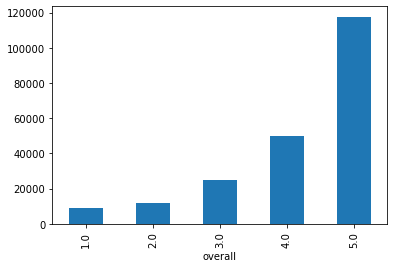

In [14]:
df_merge_new_in.groupby('overall')['reviewerID'].nunique().plot(y='reviewerID', kind='bar')

In [19]:
df_merge_new_in.groupby('asin')['overall'].mean().sort_values(ascending=False)

asin
0763638943    5.000000
1780995865    5.000000
1570544972    5.000000
0687052572    5.000000
0688008488    5.000000
                ...   
0882708627    1.324324
1589894006    1.111111
055348768X    1.000000
0545341043    1.000000
1419643797    1.000000
Name: overall, Length: 21951, dtype: float64

### 2. When did we have a lot of reviews?

In [23]:
df_merge_new_in['reviewTime_dt'] = pd.to_datetime(df_merge_new_in['reviewTime'])


In [24]:
df_date = df_merge_new_in.set_index(['reviewTime_dt'])
df_date.index

DatetimeIndex(['2013-08-02', '2003-08-17', '2001-10-01', '2005-02-11',
               '2012-08-23', '2012-02-27', '2013-12-19', '2013-06-22',
               '2013-07-30', '2008-10-03',
               ...
               '2014-06-18', '2014-07-12', '2014-07-11', '2014-07-11',
               '2014-06-16', '2014-06-23', '2014-06-23', '2014-06-23',
               '2014-06-23', '2014-06-28'],
              dtype='datetime64[ns]', name='reviewTime_dt', length=396159, freq=None)

<AxesSubplot:xlabel='reviewTime_dt'>

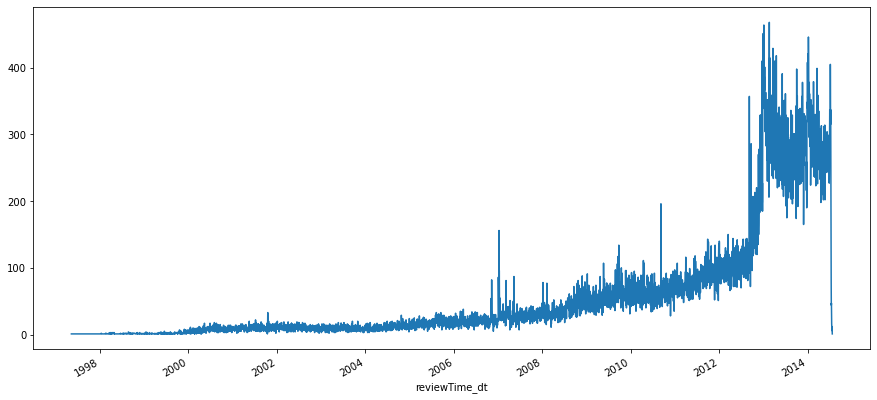

In [26]:
df_date.groupby('reviewTime_dt')['reviewerID'].nunique().plot(figsize=(15,7))